<h1>Implementing disparity constraints with a view to runtime improvements</h1>

<h2>For discussion and analysis please visit <a href="ALG_002_EXP_001-VIS.ipynb" target="_blank" rel="noopener">ALG_002_EXP_001-VIS.</a></h2>


In [1]:
###################################################################
# Built-in modules ################################################
###################################################################
import sys
import os
sys.path.append(os.path.join("..", ".."))

import numpy as np
import imp
import cv2
import matplotlib.pyplot as plt
import gc
from components.utils.CSVWriter2 import Wrapper as l
from components.utils.Metrix import Wrapper as me
import math
import time
import glob

###################################################################
# Custom modules ##################################################
###################################################################

from components.matchers.OriginalMatcher3 import Wrapper as m
from components.utils.SimpleProgressBar import SimpleProgressBar
from components.utils import utils as u
from components.utils import plot_utils as plu
from components.utils.CSVWriter2 import Wrapper as csv

import project_helpers
###################################################################
# Dataset specific modules#########################################
###################################################################

from components.utils import middlebury_utils as mbu


In [2]:

ROOT_PATH = os.path.join("..", "..")
EXPERIMENT_TITLE = "ALG_002_EXP_001-Baseline-MacLean_et_al"

INIT_METHOD = "original"
DATASET = "middlebury"

DATASET_FOLDER = os.path.join(ROOT_PATH, "datasets", DATASET)
LOG_FOLDER = os.path.join(ROOT_PATH, "experiments", "logs")
CSV_FILEPATH = os.path.join(LOG_FOLDER, EXPERIMENT_TITLE+".csv")
IMG_RES = "450X375"
PREPROCESSING_METHOD = "None"
KERNEL_SIZE = 1
KERNEL_SPEC = "None"

SCENES = ["teddy", "cones"]
SIZE=""
YEAR= 2003
EXP_PARAMS = dict()

#  Loading the dataset and visualising it

In [ ]:
loaded_imgs_and_paths = list(mbu.get_images(DATASET_FOLDER, YEAR, scene) for scene in SCENES)

for im, path in loaded_imgs_and_paths:
    filenames = list(os.path.split(p)[-1] for p in path)
    plu.plot_images(im, filenames)

### Nonoccluded regions
Errors are calculated outside the black regions.

In [ ]:
###################################################################
# 2. Occluded areas are added to the groundtruths #################
###################################################################

nonocc_gts = list()
for imgs, paths in loaded_imgs_and_paths:
    temp = mbu.add_masks_to_raw_disparity(imgs[2], imgs[3])
    nonocc_gts.append(mbu.add_masks_to_raw_disparity(imgs[2], imgs[3]))
plu.plot_images(nonocc_gts, ["teddy_nonocc_gt", "cones_nonocc_gt"])

# Benchmarking and evaluation

In [ ]:
###################################################################
# 3.1 Initialising hyperparameters and matcher#####################
###################################################################

csv_logger = csv(CSV_FILEPATH, default_header=False)
csv_logger.set_header_function(csv_logger.get_header_v3)
csv_logger.write_csv_header()
csv_logger.set_line_function(csv.format_stereo_matching_results_v2)

MATCH = 60
GAP = -20
EGAP = -1
SAVE_PATH  = os.path.join(ROOT_PATH, "experiments", "disparities", EXPERIMENT_TITLE)


EXP_PARAMS = {"experiment_id":EXPERIMENT_TITLE, "match": MATCH,"gap":GAP,"egap":EGAP,\
                  "algo":str(m.__module__), "init_method":"default","dataset":DATASET,\
                  "preprocessing_method":"None","kernel_size":1,"kernel_spec":"None"}

In [ ]:
###################################################################
# 3.2 Matching ####################################################
###################################################################

results = []
init_functions = [[m.maclean_init, "maclean_et_al"]]
for MATCH in range(20, 80, 20):
    for init_function in init_functions:
        matcher = m(MATCH, GAP, EGAP, first_rows_fill_func = init_function[0])
        EXP_PARAMS["init_method"] = init_function[1]
        EXP_PARAMS["match"] = MATCH
        for i, scene in enumerate(SCENES):

            EXP_PARAMS["scene"] = scene
            EXP_PARAMS["image_filename"] = IMAGE_FILENAME = loaded_imgs_and_paths[i][1][0]
            EXP_PARAMS["img_res"] = "{0}x{1}".format(loaded_imgs_and_paths[i][0][1].shape[1], loaded_imgs_and_paths[i][0][1].shape[0])  
            occ = loaded_imgs_and_paths[i][0][3]
            gt = loaded_imgs_and_paths[i][0][2]
            matcher.initialize(loaded_imgs_and_paths[i][0][0], loaded_imgs_and_paths[i][0][1])
            tic = time.time()
            matcher.alignImages()
            toc=time.time()
            EXP_PARAMS["runtime"] = toc-tic
            disp = matcher.lastDisparity
            disp = 4*disp

            temp_path = u.save_disparity(SAVE_PATH, disp)
            
            results.append([disp, os.path.split(temp_path)[-1]])          
            
            ###################################################################
            # Benchmarking & logging ##########################################
            ###################################################################
            
            EXP_PARAMS["image_filename"] = temp_path

            EXP_PARAMS["are_occlusions_errors"] = ARE_OCCLUSIONS_ERRORS = False
            EXP_PARAMS["bad1"], EXP_PARAMS["bad2"], EXP_PARAMS["bad4"], EXP_PARAMS["bad8"], EXP_PARAMS["ABS_ERRor"], EXP_PARAMS["mse"], EXP_PARAMS["avg"], EXP_PARAMS["eucledian"] =\
            BAD1, BAD2, BAD4, BAD8, ABS_ERR, MSE, AVG, EUCLEDIAN = me.evaluate_over_all(disp, gt, occ, occlusions_counted_in_errors = ARE_OCCLUSIONS_ERRORS)

            csv_logger.append_new_sm_results(EXP_PARAMS, selected_keys=csv.get_header_v3())


            # Here the grountruth is passed as occlusion map in order to exclude the unknown areas (black)
            # from the calculation.
            EXP_PARAMS["are_occlusions_errors"] = True


            EXP_PARAMS["bad1"], EXP_PARAMS["bad2"], EXP_PARAMS["bad4"], EXP_PARAMS["bad8"], EXP_PARAMS["ABS_ERRor"], EXP_PARAMS["mse"], EXP_PARAMS["avg"], EXP_PARAMS["eucledian"] =\
            BAD1, BAD2, BAD4, BAD8, ABS_ERR, MSE, AVG, EUCLEDIAN = me.evaluate_over_all(disp, gt, gt, occlusions_counted_in_errors = ARE_OCCLUSIONS_ERRORS)

            csv_logger.append_new_sm_results(EXP_PARAMS, selected_keys=csv.get_header_v3())

## Best results

In [3]:
import pandas as pd
experiment_log = pd.read_csv(CSV_FILEPATH)
experiment_log.sort_values(by="bad4", inplace=True) 
experiment_log.head(6)

,experiment_id,match,gap,egap,algo,init_method,dataset,scene,image_filename,img_res,...,are_occlusions_errors,abs_error,mse,avg,eucledian,bad1,bad2,bad4,bad8,runtime
1,ALG_002_EXP_001-Baseline-MacLean_et_al,20,-20,-1,components.matchers.OriginalMatcher3,maclean_et_al,middlebury,cones,experiments\disparities\ALG_002_EXP_001-Baseli...,450x375,...,False,1448822,883.241388,10.066437,11274.812640,0.643706,0.510853,0.324722,0.165835,186.511778
4,ALG_002_EXP_001-Baseline-MacLean_et_al,40,-20,-1,components.matchers.OriginalMatcher3,maclean_et_al,middlebury,teddy,experiments\disparities\ALG_002_EXP_001-Baseli...,450x375,...,False,1071431,437.558127,7.256510,8037.779233,0.674984,0.514572,0.330279,0.145146,204.650558
0,ALG_002_EXP_001-Baseline-MacLean_et_al,20,-20,-1,components.matchers.OriginalMatcher3,maclean_et_al,middlebury,teddy,experiments\disparities\ALG_002_EXP_001-Baseli...,450x375,...,False,1060665,396.702108,7.183595,7653.330190,0.688705,0.532553,0.332710,0.137554,175.276389
8,ALG_002_EXP_001-Baseline-MacLean_et_al,60,-20,-1,components.matchers.OriginalMatcher3,maclean_et_al,middlebury,teddy,experiments\disparities\ALG_002_EXP_001-Baseli...,450x375,...,False,1468417,844.006360,9.945188,11163.260410,0.661032,0.500051,0.346378,0.185546,177.591667
6,ALG_002_EXP_001-Baseline-MacLean_et_al,40,-20,-1,components.matchers.OriginalMatcher3,maclean_et_al,middlebury,cones,experiments\disparities\ALG_002_EXP_001-Baseli...,450x375,...,False,1469836,820.352904,10.212443,10866.007180,0.641774,0.515765,0.353550,0.197734,304.043652
10,ALG_002_EXP_001-Baseline-MacLean_et_al,60,-20,-1,components.matchers.OriginalMatcher3,maclean_et_al,middlebury,cones,experiments\disparities\ALG_002_EXP_001-Baseli...,450x375,...,False,1578996,807.880883,10.970888,10783.091580,0.662945,0.545767,0.393515,0.243945,167.425726


<ipython-input-4-4e26aad9974f>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-4-4e26aad9974f>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-4-4e26aad9974f>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



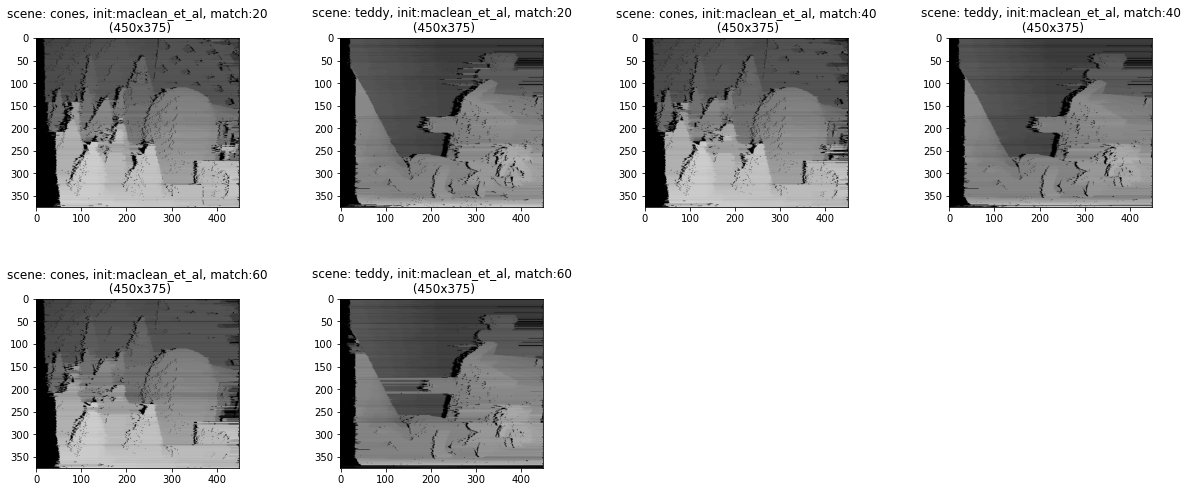

In [4]:
image_reader_func = lambda filepath: cv2.imread(str(project_helpers.fix_win_rel_paths(filepath)))

filtered_log= experiment_log[experiment_log["are_occlusions_errors"] == False]
filtered_log["loaded_imgs"] = [image_reader_func(filepath) for filepath in filtered_log["image_filename"]]
filtered_log["annotation"] = [("scene: {0}, init:{1}, match:{2}".format(scene, init, m)) for scene, init, m in filtered_log[["scene", "init_method", "match"]].values]
filtered_log.sort_values(by=["match", "scene"], inplace=True)
plu.plot_images(filtered_log["loaded_imgs"].values, filtered_log["annotation"].values)

<p>For further analysis, please visit <a href="./ALG_002_EXP_001-VIS.ipynb">ALG_002_EXP_001-VIS.</a></p>
